## Rationale

Experiment with approaches to monitor resource utlization of a process during simulation. Validate two approaches as follows:
1. Monkey-patching to decorate some methods of the resource class to inject logging behavior.
2. Run a monitoring process to poll a resource at some recurring frequency for stats.

In [21]:
# Preliminaries
from dietician_monitor import G, Patient, Consultation, patch_resource, get_monitor, Break4Lunch
from plotnine import *
from numpy import linspace, sin, cos, pi, vectorize, append, array, asarray
import pandas as pd

Note that import caches classes (and variables, functions) defined in the imported package. This has two consequences:
1. Changes to the code-base of imported module will not reflect in the Jupyter notebook simply by re-running the import statement. Either restart the Jupyter notebook's kernel or explicitly reload.
2. The class G has attributes that are class-level. These include arrays that have items appended to them during a simulation run. These arrays will accumulate history *across* simulation runs unless cleared between runs. Remember, initialization of class-level attributes happens only once, during import. Unlike object-level attributes that are initialized via constructor call each time an object is instantiated. Provide a class-level method to clear accumulators and employ this method before each independent simulation run. 

### I. Monkey-Patch Monitor

Use the ```monitor_resource()``` method of class Consultation and pass the `dietician` as the name of the resource to monitor. Note that this method accepts a list of resource names but we have only one resource (i.e. deitician) in the model so we pass a list of one. The method gets the callback from ```get_monitor()``` function in the module 'dietician_monitor' and patches each named resource (here, dietician) using ```patch_resource()``` function from the same module.

Patching means that the get/put or request/release methods of the target resource are decorated to execute the callback before or after according to how the callback is passed. Use argument ```pre=``` to pass a callback that is executed before any of these resource methods and ```post=``` to pass a callback for execution afterwards. We have passed the callback to execute afterwards.

In [22]:
c = Consultation()
G.simulation_horizon = 30
c.monitor_resource()
res = c.run_once()

Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 2 entered the queue at 0.84
Patient 1 exited at 15.19, having spent 15.19 in clinic.
Patient 2 entered consultation at 15.19, having waited 14.35
Patient 3 entered the queue at 25.64
Patient 4 entered the queue at 27.80


Now obtain the results of the lone simulation run from class G. The attribute ```resource_monitor``` has tuples with the timestamp, the resource capacity employed and the resource capacity awaited. Compare the simulated trajectory from printed output with the contents of ```G.resource_monitor```. The first patient sees the dietician immediately, so the timestamp 0 has count 1 and awaited 0. 

In [23]:
# Plot
print(G.resource_monitor)
print(G.arrived)
#x_dietcian, y_dietician = list(zip(*G.resource_monitor["dietician"]))

{'dietician': [(0, 1, 0), (0.8366434324427491, 1, 1), (15.186425307611659, 1, 0), (25.641955665527615, 1, 1), (27.804691416209558, 1, 2)]}
[0, 0.8366434324427491, 25.641955665527615, 27.804691416209558]


Thence, observe the following with each event:
1. A patient enters the queue and the capacity awaited is incremented by 1.
2. A patient enters consultation and the capacity employed is incremented by 1.
3. A patient exits after consultation, the capacity employed decreases by 1. 

When a patient is in queue waiting for consultation, then they should see the dietician as soon as available. One consultation begins as soon as the other ends. **HOWEVER** we note that this is reflected in the printed output but not in the monitor from monkey-patched resource methods. 

## Why?

Because monkey-patching has decorated the target resource's get/put or request/release methods. This misses the scenario when capacity released by one entity is immediately seized by the entity next-in-line. A resource has no method for capacity allocated, only capacity requested or released. Therefore, when resource capacity is requested, one of two log-events can occur: (1.) the entity is queued, in which case the capacity awaited is incremented by 1 (2.) the entity is served, in which case the capacity employed is incremented by 1. Capacity allocated after a delay is not tracked.

## Unfortunately, this corrupts the data collected to describe resource utilization.

**FIXED!** Added function 'help_monitor' to address the reporting gap. 

Let us see how the alternative approach fares.

## II. Monitor via Parallel Polling Process

This approach launches a process with the sole purpose of gathering data in the shared environment with the main process. Run the ```monitor_resource()``` method of class Consultation with ```proc_monitor=True```. Data are collected at regular time intervals. Contrast this with data collection when events occur in the monkey-patch approach. The data are gathered at finer resolution than the simulation step, e.g. 0.25 of a simulation time-step. (Think of Nyquist theorem.) 

In [24]:
c = Consultation()
G.simulation_horizon = 12
c.monitor_resource()
sim_res = c.run_once(proc_monitor=True)

Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 1 exited at 6.35, having spent 6.35 in clinic.
Patient 2 entered the queue at 10.11
Patient 2 entered consultation at 10.11, having waited 0.00
Patient 2 exited at 10.46, having spent 0.35 in clinic.


In [25]:
print(G.resource_monitor)
print(G.resource_utilization)

{'dietician': [(0, 1, 0), (6.351644908205531, 0, 0), (10.111390179534734, 1, 0), (10.462648989151113, 0, 0)]}
{'dietician': [(0, 0, 0), (0.25, 1, 0), (0.5, 1, 0), (0.75, 1, 0), (1.0, 1, 0), (1.25, 1, 0), (1.5, 1, 0), (1.75, 1, 0), (2.0, 1, 0), (2.25, 1, 0), (2.5, 1, 0), (2.75, 1, 0), (3.0, 1, 0), (3.25, 1, 0), (3.5, 1, 0), (3.75, 1, 0), (4.0, 1, 0), (4.25, 1, 0), (4.5, 1, 0), (4.75, 1, 0), (5.0, 1, 0), (5.25, 1, 0), (5.5, 1, 0), (5.75, 1, 0), (6.0, 1, 0), (6.25, 1, 0), (6.5, 0, 0), (6.75, 0, 0), (7.0, 0, 0), (7.25, 0, 0), (7.5, 0, 0), (7.75, 0, 0), (8.0, 0, 0), (8.25, 0, 0), (8.5, 0, 0), (8.75, 0, 0), (9.0, 0, 0), (9.25, 0, 0), (9.5, 0, 0), (9.75, 0, 0), (10.0, 0, 0), (10.25, 1, 0), (10.5, 0, 0), (10.75, 0, 0), (11.0, 0, 0), (11.25, 0, 0), (11.5, 0, 0), (11.75, 0, 0)]}


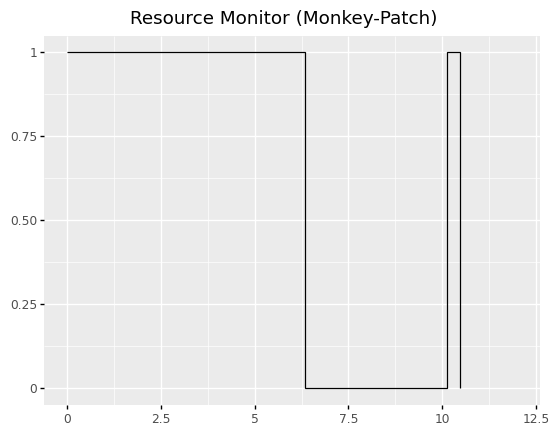

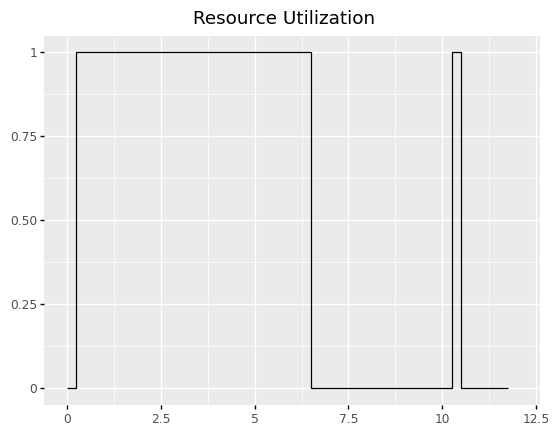

<ggplot: (325169345)>

In [26]:
x_monkey, y_monkey, _ = list(zip(*G.resource_monitor["dietician"]))
x_monitr, y_monitr, _ = list(zip(*G.resource_utilization['dietician']))

pMonkey = ggplot(aes(x=x_monkey, y=y_monkey)) \
            + geom_step() \
            + xlim(0, G.simulation_horizon) \
            + ggtitle("Resource Monitor (Monkey-Patch)")
ggplot.draw(pMonkey)
pMonitr = ggplot(aes(x=x_monitr, y=y_monitr)) \
            + geom_step() \
            + xlim(0, G.simulation_horizon) \
            + ggtitle("Resource Utilization")
pMonitr

Let's generate a utilization metric as Area Under Curve AUC). Use ```trapz()``` from ```numpy``` for numerical integration. This works for numerical integration of a function sampled at regular intervals and appears problematic with irregular interavals. Hence, prefer polling over  monkey-patching here. The latter will require hand-coding the numerical integration. 

In [27]:
from numpy import trapz
avaUtil = G.number_of_dieticians * x_monitr[-1]
netUtil = trapz(y_monitr, x_monitr) 
percUtil = netUtil / avaUtil * 100
print("Dietician reported percentage utilization of {:.2f}={:.2f}/{:.2f}".format(percUtil, netUtil, avaUtil))
print("Dietician reported percentage utilization of {:.2f} from run metrics".format(sim_res.get("utilization")*100))

Dietician reported percentage utilization of 55.32=6.50/11.75
Dietician reported percentage utilization of 55.32 from run metrics


## CONCLUSION

We have tested two approaches to monitor process during simulation and track resource utilization. The monkey-patching approach decorates some methods of a resource (get/put or request/release) to inject logging behavior before/after. The method is elegant. Use with caution for the following reasons:
1. Code is relatively complex but flexible.
2. Logging is event-driven, i.e. as an when a get/put or request/release method is called.
3. Does not record capacity allocated after delay, only capacity requested, potentially corrupting logs.

The alternative is a process in shared environment with the main process. This polls the target resource for stats that are accumulated in an array. Caveat is that polling in less efficient.

*RECOMMENDATION* We've fixed the issue with monkey-patching by adding a helper function. The code now has three functions that work together for monkey-patching as follows:
1. ```patch_resource()```: Implements the decorator pattern to inject logging before/after calls to get/put or request/release methods of resource class.
2. ```get_monitor()```: Returns the callback that is passed as argument ```pre=``` or ```post=``` of ```patch_resource()```.
3. ```help_monitor()```: Updates the data-structure (dictionary of lists) that stores data from monitoring process when capacity requested is allocated after a delay. 

These functions are independent of the process being modeled. The class ```Consultation``` uses these functions for monkey-patching as follows:
1. Method ```monitor_resource()``` obtains a callback instance for each resource with ```get_monitor()``` and monkey-patches it with ```patch_resource()```. 
2. Calls ```help_monitor()``` after a request is fullfilled.

Note that the class ```G``` must have attributes set up for monitoring that ```Consultation``` can stream payloads to.

## EXTRA

Some exploratory commands. Ignore.

In [28]:
import simpy
env = simpy.Environment
res = simpy.Resource(env=env, capacity=1)
print(type(res))
type(res) == 'simpy.resources.resource.Resource'
isinstance(res, simpy.resources.resource.Resource)

<class 'simpy.resources.resource.Resource'>


True

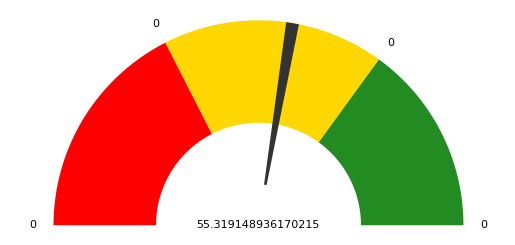

<ggplot: (325220259)>

In [29]:
from plotnine import *

def gggauge(pos, breaks=asarray([0, 30, 70, 100]), r_inner=0.5, r_outer=1.0):
    def get_poly(a, b, r_inner=r_inner, r_outer=r_outer):
        
        theta_start = pi * (1 - a/100)
        theta_end   = pi * (1 - b/100)
        theta       = linspace(theta_start, theta_end, 100)
        x           = append(r_inner * cos(theta), r_outer * cos(theta)[::-1]) 
        y           = append(r_inner * sin(theta), r_outer * sin(theta)[::-1]) 
        return pd.DataFrame({'x': x,'y': y})

    df_r = get_poly(breaks[0],breaks[1])
    df_g = get_poly(breaks[1],breaks[2])
    df_f = get_poly(breaks[2],breaks[3])
    df_m = get_poly(pos-1,pos+1,0.2)

    return ggplot() \
        + geom_polygon(data=df_r, mapping=aes(df_r["x"], df_r["y"]), fill="red" ) \
        + geom_polygon(data=df_g, mapping=aes(df_g["x"], df_g["y"]), fill="gold") \
        + geom_polygon(data=df_f, mapping=aes(df_f["x"], df_f["y"]), fill="forestgreen") \
        + geom_polygon(data=df_m, mapping=aes(df_m["x"], df_m["y"])) \
        + geom_text(data=pd.DataFrame(breaks), size=8, fontstyle="normal",
                mapping=aes(x=1.1*r_outer*cos(pi*(1-breaks/100)),y=1.1*r_outer*sin(pi*(1-breaks/100)),label="%".join(map(str, breaks)))) \
        + annotate("text", x=0, y=0, label=pos, size=8, fontstyle="normal") \
        + coord_fixed() \
        + theme_bw() \
        + theme(axis_text=element_blank(),
                axis_title=element_blank(),
                axis_ticks=element_blank(),
                panel_grid=element_blank(),
                panel_border=element_blank()) 

ggg = gggauge(percUtil,breaks=asarray([0, 35, 70, 100]))
ggg